### Search using facebook FAISS
[faiss](https://github.com/facebookresearch/faiss)

In [14]:
import json
# Used to import data from S3.
import pandas as pd

# Used to create the dense document vectors.
import torch
from sentence_transformers import SentenceTransformer

# Used to create and store the Faiss index.
import faiss
import numpy as np
import pickle
import matplotlib.pyplot as plt

# Used to do vector searches and display the results.
#from vector_engine.utils import vector_search, id2details

### Import
Import the file exported from the excel file

In [208]:
with open('D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/primitiveDef.json') as json_file:
    primitiveDef = json.load(json_file)

#print(primitiveDef)

# Preprocessing
Follow guide from: https://www.pinecone.io/learn/faiss-tutorial/

In [209]:
# remove duplicates
primitiveDefSing = [word for word in list(set(primitiveDef)) if type(word) is str]

In [210]:
from sentence_transformers import SentenceTransformer
# initialize sentence transformer model
#model = SentenceTransformer('bert-base-nli-mean-tokens') #this is outdated: https://huggingface.co/sentence-transformers/bert-base-nli-mean-tokens
model = SentenceTransformer('all-mpnet-base-v2')
# create sentence embeddings
sentence_embeddings = model.encode(primitiveDefSing)
sentence_embeddings.shape

(147, 768)

In [211]:
import faiss

d = sentence_embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.is_trained
index.add(sentence_embeddings)
index.ntotal
print(len(sentence_embeddings[0]))

768


Here he use the clustering provided in the [faiss-wiki](https://github.com/facebookresearch/faiss/wiki/Faiss-building-blocks:-clustering,-PCA,-quantization)

In [213]:
# We decompose with sklearn PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(sentence_embeddings)

x = principalComponents[:,0].tolist()
y = principalComponents[:,1].tolist()
principalComponents = np.ascontiguousarray(principalComponents)

# We decompose with faiss PCA
mat = faiss.PCAMatrix(768, 2)
mat.train(sentence_embeddings)
assert mat.is_trained
tr = mat.apply_py(sentence_embeddings)
xf = tr[:,0].tolist()
yf = tr[:,1].tolist()

In [217]:
# dataset = tr
# dataset = principalComponents
dataset = sentence_embeddings

d = dataset.shape[1]
index = faiss.IndexFlatL2(d)
index.is_trained
index.add(dataset)
index.ntotal
ncentroids = 35
niter = 20
verbose = True
kmeans = faiss.Kmeans(d, ncentroids, niter=niter, verbose=verbose)
kmeans.train(dataset)
print(len(kmeans.centroids))

35


In [256]:
D, I = kmeans.index.search(dataset, 1)
#print(D)
#print(I[:,0])
Ilist = I[:,0].tolist()
Dlist = D[:,0].tolist()
#print(Ilist)
d = {'primitive':primitiveDefSing, 'cluster':Ilist, 'distance':Dlist, 'x': xf, 'y': yf}
#print(d)

cluster = pd.DataFrame(d)
#print(cluster.head())


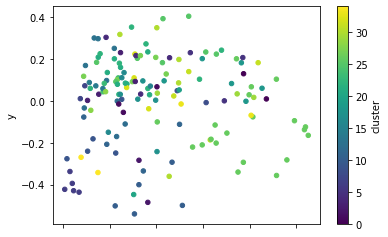

In [258]:
# Create scatter upon cluster type
ax1 = cluster.plot.scatter(x='x', y='y', c='cluster', colormap='viridis')    

35


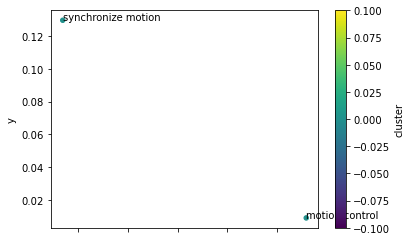

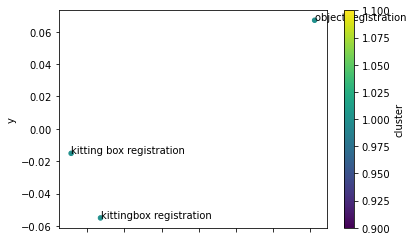

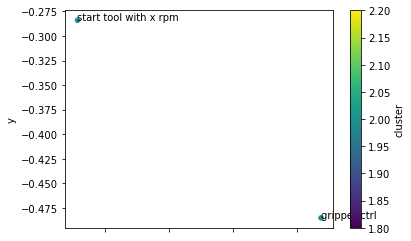

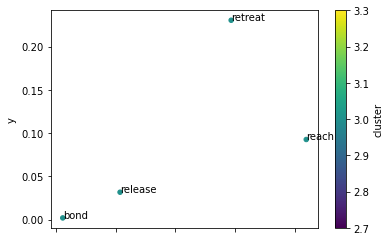

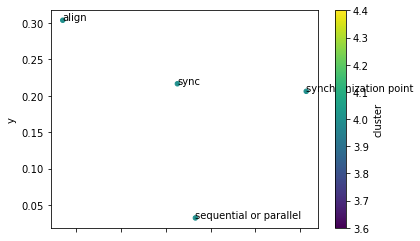

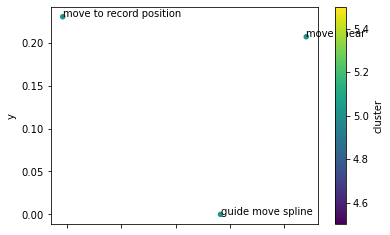

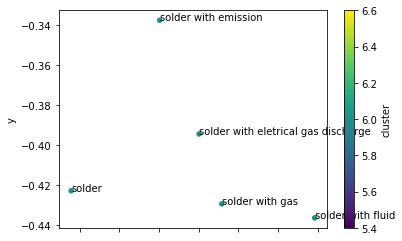

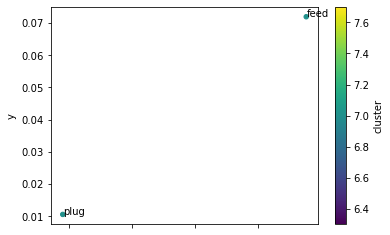

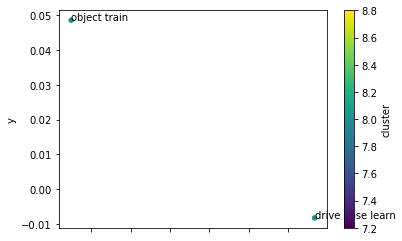

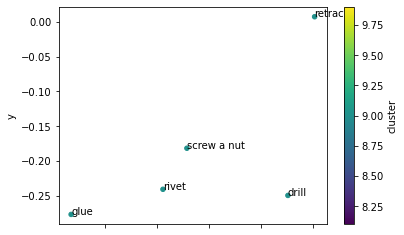

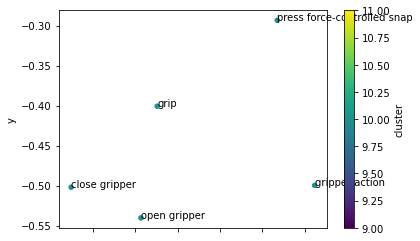

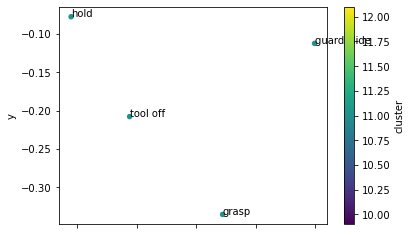

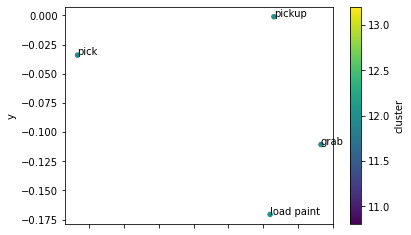

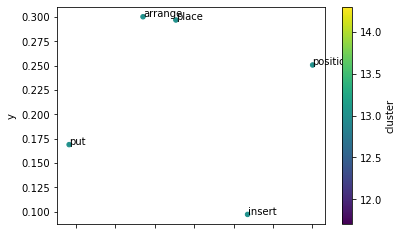

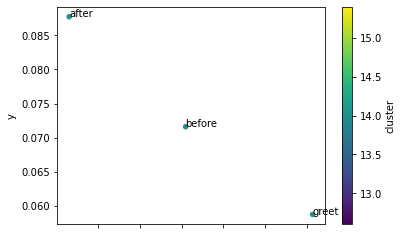

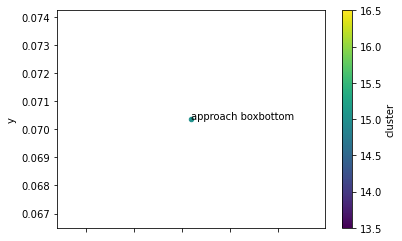

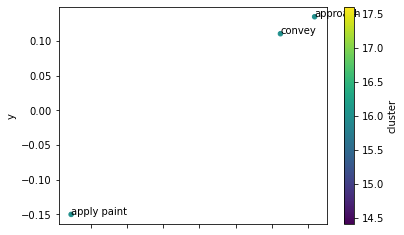

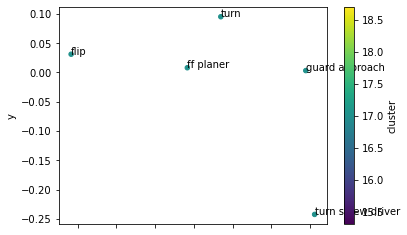

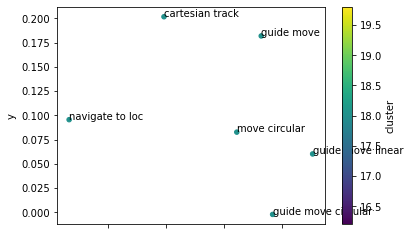

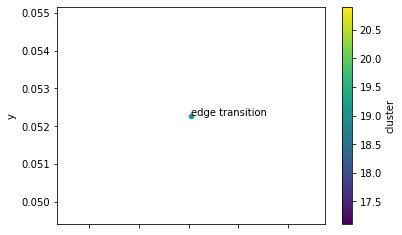

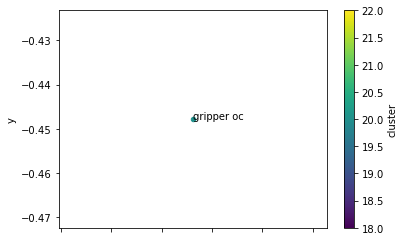

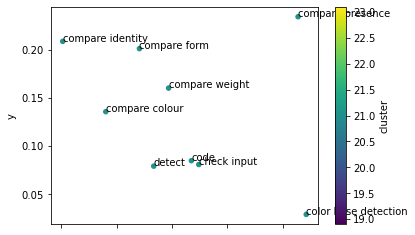

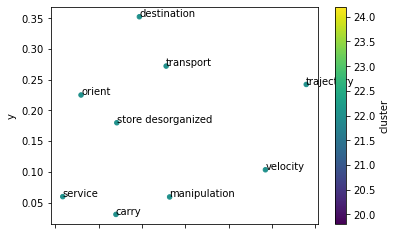

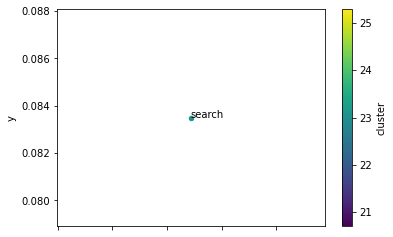

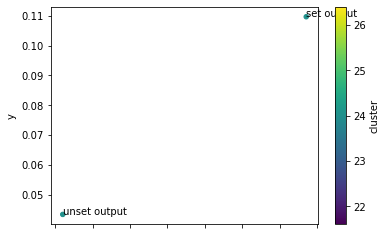

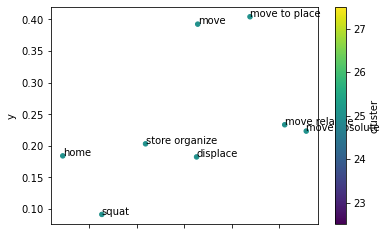

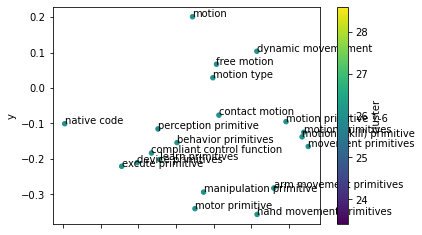

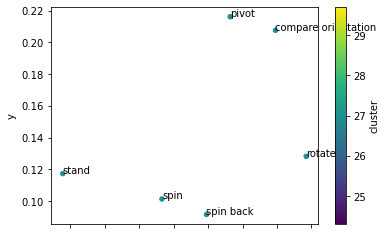

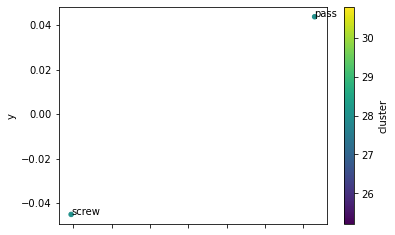

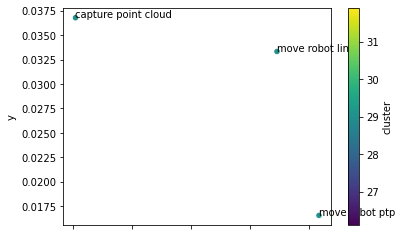

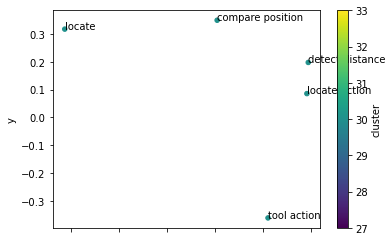

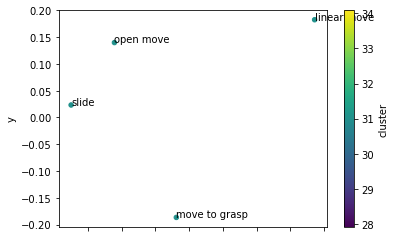

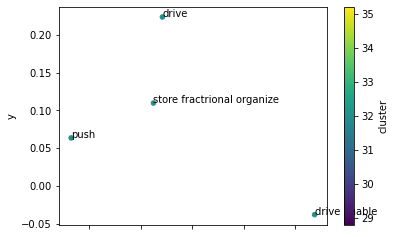

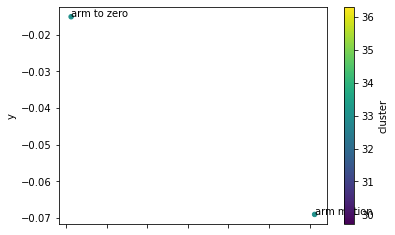

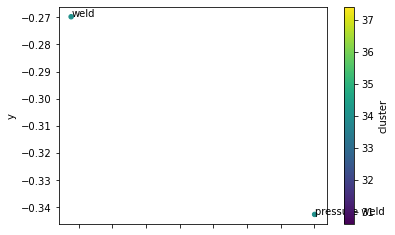

In [270]:
byCluster = cluster.groupby('cluster')

print(len(byCluster))

for clusterNr in range(len(byCluster)):
  #print(clusterGroup)

  displayCluster = byCluster.get_group(clusterNr)

  #print(displayCluster)

  ax1 = displayCluster.plot.scatter(x='x', y='y', c='cluster', colormap='viridis')

  # Plot name for each datapoint
  for idx, row in displayCluster.iterrows(): 
    plt.text(row['x'], row['y'], row['primitive'])

  plt.savefig("D:/1. Papers/4. MyPapers/6_(20210609) Skill taxonomy/skill-taxonomy-extraction/data/out/" + str(clusterNr) + ".png")
    